From `analysis_notebooks/burst_cut.ipynb`

In [1]:
import numpy as np
import math
import matplotlib.ticker
from matplotlib.pyplot import *
style.use('../mplstyles/stylelib/standard.mplstyle')
from tqdm import tqdm_notebook
from scipy import optimize
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, mark_inset)

get_backend()

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if __name__ == '__main__':


'module://ipykernel.pylab.backend_inline'

In [2]:
#*    Row   *   PTOFkeV * in50_1000 * dN_50_100 * dN_50_100 *
RQ_names=['Entry','PTOFkeV','in50_1000', 'dN_pre', 'dN_post']
data_types=['bkg','Na','PuBe']
data={'bkg':{},'Na':{},'PuBe':{}}

for dtype in data_types:
    with open(f'../analysis_notebooks/data/r68_n125_{dtype}_cok_2keV.txt', "r") as text:
        lines=np.array([np.array(line.replace("*","").split()).astype(np.float) for line in text.readlines()[3:-2]])
        data[dtype]['lines']=lines
        data[dtype]['Nevents']=len(lines)
        for i,RQ in enumerate(RQ_names):
            data[dtype][RQ]=lines[:,i]
        data[dtype]['in50_1000']=data[dtype]['in50_1000'].astype(bool)

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [3]:
#PMF of finding a gap of size dN
#Here, we're assuming dN>=1, in accordance with the definition of dN that we used
def fPMF(dN,A,p):
    return A*p*(1-p)**(dN-1)

In [4]:
#Fitting routine using bootstrap method to estimate parameter uncertainties
#Stolen from: https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
#Modified to just use yerr instead of stdev of residuals since residuals are x-dependent
def fit_bootstrap(function, datax, datay, sigmay, p0, Nsigma=1, Nsim=100):

    errfunc = lambda p, x, y, sigy: (function(x,*p) - y)/sigy

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay, sigmay), full_output=0)

    # Nsim random data sets are generated and fitted
    ps = []
    for i in range(Nsim):

        randomDelta = np.random.normal(0., sigmay)
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY,sigmay),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)
    err_pfit = Nsigma * np.std(ps,0) 

    return mean_pfit, err_pfit

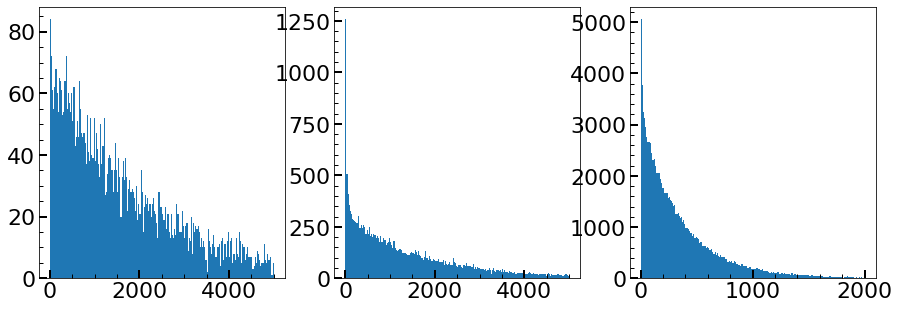

In [5]:
#Preliminary plot - must format data for histogram to complete final plot

fig,axs=subplots(1,3,figsize=(15,5));

binss=[np.linspace(0,5e3,201),np.linspace(0,5e3,201),np.linspace(0,2e3,201)];
bctrs=[(bs[:-1]+bs[1:])/2 for bs in binss];
cfits=[(bctrs[0]>1) & (bctrs[0]<5e3), (bctrs[1]>250), (bctrs[2]>250)];

for dtype,ax,bins,cfit in zip(data_types,axs,binss,cfits):
    c,b,_=ax.hist(data[dtype]['dN_pre'][data[dtype]['in50_1000']],bins=bins,label=f"NdN={np.sum(data[dtype]['in50_1000']):.3g}");
    bctr=(b[:-1]+b[1:])/2    
    
    #pmf
    popt,pcov=curve_fit(fPMF,bctr[cfit],c[cfit],p0=[1e3,1e-3])
    perr=np.sqrt(np.diag(pcov))

    data[dtype]['popt']=popt
    data[dtype]['perr']=perr
    data[dtype]['p']=popt[1]
    data[dtype]['NdN']=np.sum(data[dtype]['in50_1000'])
    data[dtype]['NdN_good']=popt[0]/(b[1]-b[0])

In [6]:
#Cut effects
def dNeff(dN,p):
    return (1-p)**(2*(dN-1)+2)
def eff2dN(eff,p):
    return 0.5*math.log(eff,1-p)

dNs=np.linspace(0,5000,100)

In [7]:
#Ebins=np.linspace(50,500,181)
Ebins=np.linspace(50,500,91)
Ebctr=(Ebins[:-1]+Ebins[1:])/2
eff_target=np.linspace(1,0.5,41)
for dtype in tqdm_notebook(data_types):
    data[dtype]['dN_cuts']=[]
    data[dtype]['dN_Npass']=[]
    data[dtype]['cs']=[]
    for eff in eff_target:
        #Pick the dN cut level
        if eff==1:
            dN_cut=0
        else:
            dN_cut=eff2dN(eff,data[dtype]['p'])
            
        data[dtype]['dN_cuts'].append(dN_cut)
        cut=(data[dtype]['in50_1000']==1) & (data[dtype]['dN_pre']>dN_cut) & (data[dtype]['dN_post']>dN_cut)
        data[dtype]['dN_Npass'].append(np.sum(cut))
        c,b=np.histogram(1e3*data[dtype]['PTOFkeV'][cut],bins=Ebins);
        data[dtype]['cs'].append(c)
    
    data[dtype]['dN_cuts']=np.array(data[dtype]['dN_cuts'])
    data[dtype]['dN_Npass']=np.array(data[dtype]['dN_Npass'])
    data[dtype]['cs']=np.array(data[dtype]['cs'])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/3 [00:00<?, ?it/s]

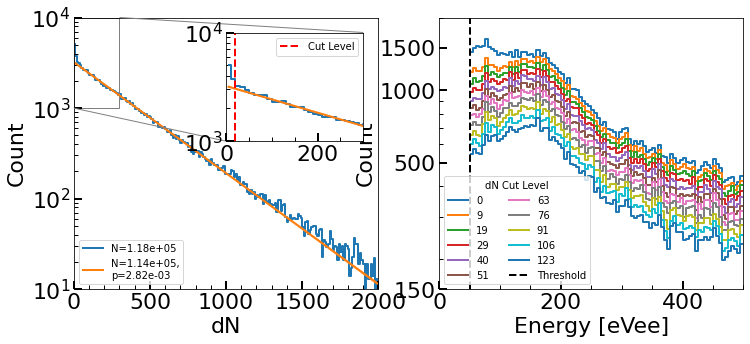

In [8]:
#Nice plot for the paper
fig,axs=subplots(1,2,figsize=(12,5))
dtype='PuBe'
popt=data[dtype]['popt']
perr=data[dtype]['perr']

c,b=np.histogram(data[dtype]['dN_pre'][data[dtype]['in50_1000']],bins=bins)
bctr=(b[:-1]+b[1:])/2
axs[0].step(bctr,c,where='mid',linewidth=2,label=f"N={np.sum(data[dtype]['in50_1000']):.3g}",zorder=0);

axs[0].fill_between(bctr,fPMF(bctr,popt[0]+perr[0], popt[1]+perr[1]),fPMF(bctr,popt[0]-perr[0], popt[1]-perr[1]),color='C1',alpha=0.5)
axs[0].plot(bctr,fPMF(bctr,*popt),linewidth=2,label=f"N={data[dtype]['NdN_good']:.2e},\np={popt[1]:.2e}")
                  
axs[0].set_yscale('log')
axs[0].set_xlim(0,2000)
axs[0].set_ylim(1e1,1e4)
axs[0].set_xlabel('dN')
axs[0].set_ylabel('Count')
axs[0].legend(loc='lower left')

#Inset zoom in 
axins0 = inset_axes(axs[0], width="45%", height="40%", loc=1, borderpad=1.5)
mark_inset(axs[0], axins0, loc1=1, loc2=3, fc="none", ec='0.5')
axins0.step(bctr,c,where='mid',linewidth=2);
axins0.fill_between(bctr,fPMF(bctr,popt[0]+perr[0], popt[1]+perr[1]),fPMF(bctr,popt[0]-perr[0], popt[1]-perr[1]),color='C1',alpha=0.5)
axins0.plot(bctr,fPMF(bctr,*popt),linewidth=2)
axins0.axvline(20,color='r',linestyle='--',label='Cut Level')
            
axins0.set_yscale('log')
axins0.set_xlim(0,300)
axins0.set_ylim(1e3,1e4)
axins0.legend(loc='upper right')
            
#Energy hists
for i in range(len(data[dtype]['cs']))[::4]:
    c=data[dtype]['cs'][i]
    dNc=data[dtype]['dN_cuts'][i]
    eff=eff_target[i]
    axs[1].step(Ebctr,c,where='mid',label=f'{dNc:.0f}')#label=f'{eff:.1f}')

axs[1].axvline(50,linestyle='--',color='k', label='Threshold')

axs[1].set_yscale('log')
axs[1].set_ylim(150,2e3)
axs[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].set_yticks([150,500,1e3,1.5e3])
axs[1].get_yaxis().set_tick_params(which='minor', labelleft=False) 

axs[1].set_xlim(0,500)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Count')
axs[1].legend(ncol=2,title='dN Cut Level',loc='lower left')

show()